# Physics Informed Neural Network (PINN)

In [1]:
# simple demo of PINN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from src.models import Regular_NN, PINN, G

In [2]:
# set seed for reproducibility
SEED = 86845635 # this seeds shows that boundary condition is important
np.random.seed(SEED)
torch.manual_seed(SEED)



We will demo a simple physics-informed neural network (PINN) to model the motion of a free-falling object under gravity. The governing equation is given by Newton's second law:

$\frac{d^2y}{dt^2} = -g$

where $y$ is the position of the object, $t$ is time, and $g$ is the acceleration due to gravity (approximately 9.81 m/s²).
                                                                                                  
Basically, we are modelling a parabola.

We will try three different approaches:
1. Standard Neural Network (NN) without physics constraints.
2. PINN, which includes the physics constraints in the loss function.
3. PINN with added boundary constraints (i.e., initial and final positions).

We will compare the performance of these models in terms of their ability to predict the motion of the falling object.

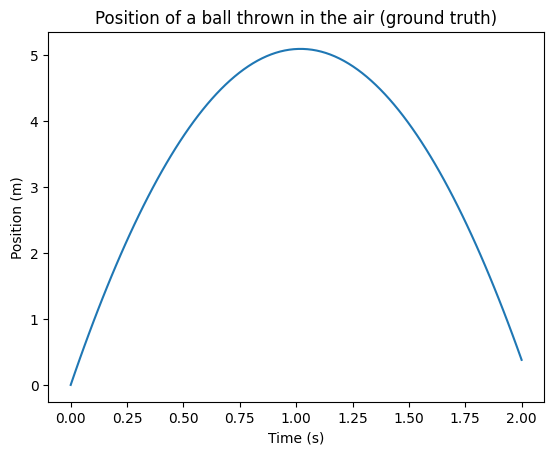

In [3]:
# simple demo of PINN

# first, we create a dataset of a parabola, simulating a ball thrown in the air

def generate_data(num_points=100):
    # time from 0 to 2 seconds
    t = np.linspace(0, 2, num_points)
    # position y = -0.5*G * t^2 + 10t (assuming initial velocity of 10 m/s)
    y = -0.5*G * t**2 + 10 * t
    return t, y

# plot the generated data
t, y = generate_data()
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position of a ball thrown in the air (ground truth)')
plt.show()

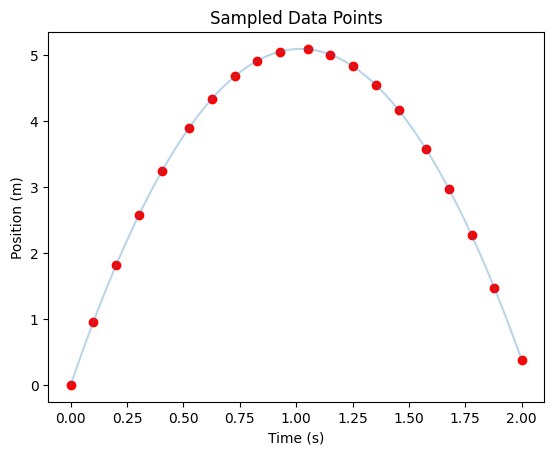

In [4]:
# Let's sample some points from this dataset to train our PINN
def sample_data(t, y, num_samples=20):
    # sample the point evenly over time
    indices = np.linspace(0, len(t)-1, num_samples).astype(int)
    return t[indices], y[indices]

t_samples, y_samples = sample_data(t, y)
plt.scatter(t_samples, y_samples, color='red')
plt.plot(t, y, alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Sampled Data Points')
plt.show()

Now, we add noise to the sampled data to simulate real-world measurements.

Additionally, I added a `add_random_offset` function to further add random offsets to the noisy data points, simulating measurement errors.

With the noisy data, we hypothesise that the classic NN model may end up overfitting the noise and disobeying the physics of the system. 

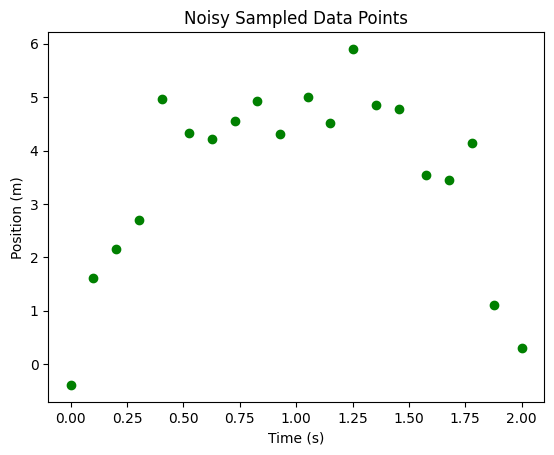

In [5]:
# now, add noise to the data
def add_noise(y, noise_level=0.5):
    noise = noise_level * np.random.randn(*y.shape)
    return y + noise

# also, randomly offset some points, to simulate errors in measurement
def add_random_offsets(y, num_offsets=5, offset_magnitude=3.0):
    indices = np.random.choice(len(y), num_offsets, replace=False)
    for idx in indices:
        y[idx] += offset_magnitude * (2 * np.random.rand() - 1)  # random offset between -magnitude and +magnitude
    return y

y_noisy = add_noise(y_samples)
y_noisy = add_random_offsets(y_noisy, num_offsets=5, offset_magnitude=3.0)
plt.scatter(t_samples, y_noisy, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Noisy Sampled Data Points')
plt.show()

In [6]:
# now, create dataframe of the noisy data, with the ground truth labels

df = pd.DataFrame({
    'time': t_samples,
    'position_noisy': y_noisy,
    'position_true': y_samples
})

df.head()

,time,position_noisy,position_true
0,0.00000,-0.388318,0.000000
1,0.10101,1.616949,0.960055
2,0.20202,2.154861,1.820018
3,0.30303,2.698860,2.579890
4,0.40404,4.965661,3.239669


In [7]:
# prepare data for training
t_tensor = torch.tensor(t_samples, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y_noisy, dtype=torch.float32).view(-1, 1)


In [8]:
model = Regular_NN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
# training loop
model.train_model(t_tensor, y_tensor, 
                  criterion, optimizer,
                  num_epochs=1000
                )


Epoch [100/1000], Loss: 0.9827
Epoch [200/1000], Loss: 0.3804
Epoch [300/1000], Loss: 0.3274
Epoch [400/1000], Loss: 0.3011
Epoch [500/1000], Loss: 0.2670
Epoch [600/1000], Loss: 0.2289
Epoch [700/1000], Loss: 0.1929
Epoch [800/1000], Loss: 0.1553
Epoch [900/1000], Loss: 0.1205
Epoch [1000/1000], Loss: 0.0875


In [10]:
# evaluate the model
model.eval()
with torch.no_grad():
    t_test = torch.tensor(t, dtype=torch.float32).view(-1, 1)
    y_pred = model(t_test).numpy().flatten()
    

In [11]:
# declare plot function
def plot_results(t, y_true, y_pred, title='PINN Results'):
    plt.plot(t, y_true, label='True Position', color='blue')
    plt.plot(t, y_pred, label='Predicted Position', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title(title)
    plt.legend()
    plt.show()

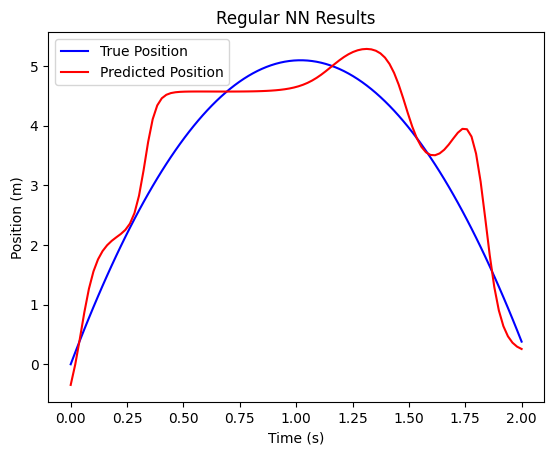

In [12]:
# plot results of regular NN
plot_results(t, y, y_pred, title='Regular NN Results')

Clearly, we see the regular NN overfitting the noisy data, resulting in a high-order polynomial-like curve.

In [13]:
# declare PINN model
model_pinn = PINN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=0.01)

In [14]:
# training loop for PINN (without boundary constraints)
model_pinn.train_model(t_tensor, y_tensor, 
                       criterion, optimizer,
                       num_epochs=1000, 
                       lambda_phys=1, # weight for physics loss
                       lambda_bc=0  # weight for boundary constraints. we set to 0 first
                    )



Epoch [100/1000], Loss: 26.6537
Epoch [200/1000], Loss: 24.9860
Epoch [300/1000], Loss: 24.8306
Epoch [400/1000], Loss: 24.3631
Epoch [500/1000], Loss: 23.4925
Epoch [600/1000], Loss: 21.3285
Epoch [700/1000], Loss: 20.1568
Epoch [800/1000], Loss: 19.8042
Epoch [900/1000], Loss: 18.6157
Epoch [1000/1000], Loss: 28.0311


In [15]:
# evaluate the model
model_pinn.eval()
with torch.no_grad():
    t_test = torch.tensor(t, dtype=torch.float32).view(-1, 1)
    y_pred_pinn = model_pinn(t_test).numpy().flatten()


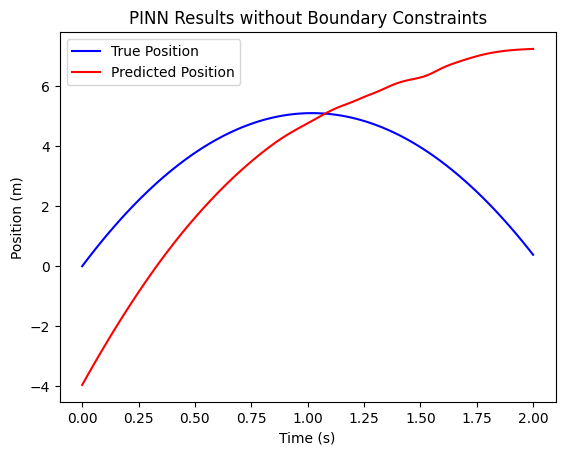

In [16]:
# plot results of PINN 
plot_results(t, y, y_pred_pinn, title='PINN Results without Boundary Constraints')

With the physics loss added, we see that the model is coerced to predict a parabolic trajectory. However, given how noisy the data is, the starting and end points of the curve are off, with the curve starting underground and ending above ground, without landing.

In [17]:
# now, train with boundary constraints enabled
model_pinn_bc = PINN()
optimizer = torch.optim.Adam(model_pinn_bc.parameters(), lr=0.01)
criterion = nn.MSELoss()

model_pinn_bc.train_model(t_tensor, y_tensor, 
                         criterion, optimizer,
                         num_epochs=1000, 
                         lambda_phys=1, # weight for physics loss
                         lambda_bc=10  # weight for boundary constraints
                        )

Epoch [100/1000], Loss: 0.8409
Epoch [200/1000], Loss: 0.6512
Epoch [300/1000], Loss: 0.8510
Epoch [400/1000], Loss: 0.6338
Epoch [500/1000], Loss: 0.6329
Epoch [600/1000], Loss: 0.7284
Epoch [700/1000], Loss: 0.6321
Epoch [800/1000], Loss: 0.6337
Epoch [900/1000], Loss: 0.6318
Epoch [1000/1000], Loss: 0.6361


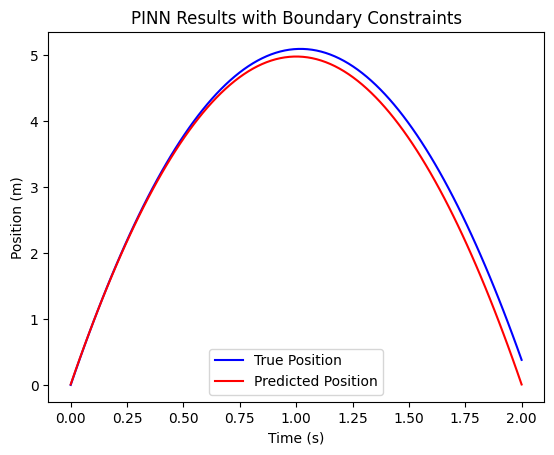

In [18]:
model_pinn_bc.eval()
with torch.no_grad():
    t_test = torch.tensor(t, dtype=torch.float32).view(-1, 1)
    y_pred_pinn_bc = model_pinn_bc(t_test).numpy().flatten()

# plot results of PINN with boundary constraints
plot_results(t, y, y_pred_pinn_bc, title='PINN Results with Boundary Constraints')


Now, with the boundary conditions added, the PINN has managed to confine the start and end points to the ground level (y=0), along with a parabolic path (order 2 curve), which is consistent with the physics of projectile motion under gravity.